In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

In [2]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, pil_image.size, Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  global display_str
  global name_list
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()
  name_list = []
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      name_list.append(display_str)
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

# Loading the Model
You can change the module_handle to the file name if you have already installed the model.

In [3]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [5]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

In [12]:
def run_detector(detector, path, save_filename):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  save_img = Image.fromarray(image_with_boxes)
  save_img.save(f'/content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App/src/static/detections/{save_filename}')
  display_image(image_with_boxes)

# Flask App

 * Serving Flask app "rogi" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://a61b849954ba.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [15/Feb/2021 10:47:17] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Feb/2021 10:47:18] "GET /static/css/main.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Feb/2021 10:47:19] "GET /favicon.ico HTTP/1.1" 404 -


Found 100 objects.
Inference time:  39.78092122077942
['Human face: 97%', 'Human face: 96%', 'Human face: 95%', 'Human face: 94%', 'Man: 88%', 'Man: 80%', 'Clothing: 70%', 'Boy: 67%', 'Clothing: 58%', 'Glasses: 52%']


INFO:werkzeug:127.0.0.1 - - [15/Feb/2021 10:48:08] "POST /uploader HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Feb/2021 10:48:09] "GET /static/detections/lol.jpg HTTP/1.1" 200 -


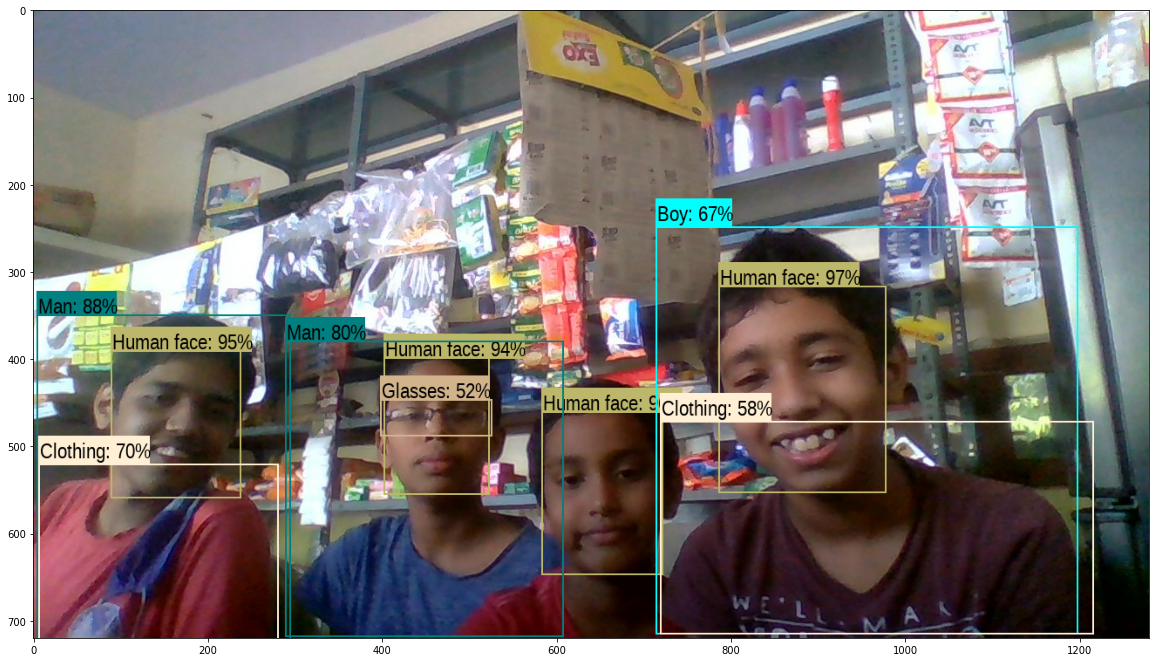

In [13]:
# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok
import os


__file__ = "/content/drive/MyDrive/Colab Notebooks/rogi"

# Define a flask app
app = Flask(__name__, static_folder="/content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App/src/static",
            template_folder="/content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App/src/templates")

app.config['UPLOAD_FOLDER'] = "/content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App/src/static/uploads"

run_with_ngrok(app)

def allowed_file(filename):
    file_names = ["JPG", "jpg", "PNG", "png", "JPEG", "jpeg"]
    extention = filename.split(".") [1]
    if extention in file_names:
        return True
    else:
        return False

@app.route("/")
def index():
    return render_template("index.html")


@app.route('/uploader', methods=['GET', 'POST'])
def upload_file():
    detected_objects = ""
    global filename
    if request.method == 'POST':
        f = request.files['file']
        filename = secure_filename(f.filename)

    save_path = (os.path.join(app.config['UPLOAD_FOLDER'], filename))
    f.save(save_path)

    with tf.device("GPU:0"):
        run_detector(detector, save_path, save_filename=f"{filename}")
    detected_objects = name_list
    print(detected_objects)
    return render_template("uploaded.html", display_detection=filename, fname=f.filename, detected_objects=detected_objects)
    # else:
    #     return redirect(url_for("index"))

if __name__ == "__main__":
    app.run()

In [15]:
%cd /content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App
!git add -A
!git commit -m "Finshed the flask app"
!git push --set-upstream origin main

/content/drive/MyDrive/ColabNotebooks/Flask-Object-Detection-App

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@0ce3091f1b99.(none)')
Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date


In [ ]:
git config --global user.email "007rohitjj04@gmail.com"
git config --global user.name "Rohth"